1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


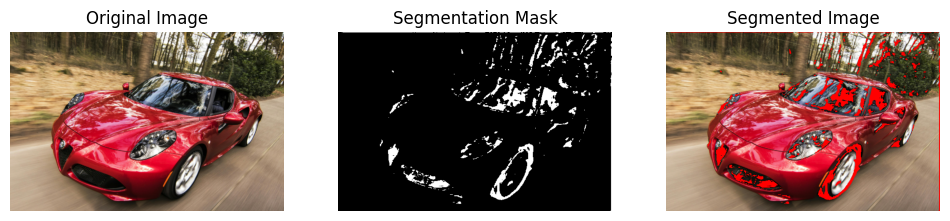

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

# U-Net Model for Segmentation
def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

# Create Model
model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Load Pretrained Weights (Train First)
# model.load_weights("your_trained_model.h5")

# Function to Segment an Image
def segment_image(image_path):
    # Check if the image file exists before loading
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return  # Exit the function if the file doesn't exist

    image = cv2.imread(image_path)
    # Check if the image was loaded successfully
    if image is None:
        print(f"Error: Failed to load image from {image_path}")
        return  # Exit the function if loading failed

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (256, 256)) / 255.0  # Normalize

    # Predict Segmentation Mask
    pred_mask = model.predict(np.expand_dims(image_resized, axis=0))[0]

    # Resize mask to original image size
    pred_mask = cv2.resize(pred_mask, (image.shape[1], image.shape[0]))

    # Convert mask to binary
    mask = (pred_mask > 0.5).astype(np.uint8) * 255

    # Overlay mask on original image
    overlay = image.copy()
    overlay[mask == 255] = [255, 0, 0]  # Red overlay

    # Display Results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Segmented Image")
    plt.axis("off")

    plt.show()

# Example Usage
segment_image("Car.png")
